# Training

- Use this notebook after you've built your dataset to train the model.
- Training will create a model directory with:
    - **`model_0000XXX.pth`**: weights that are regularly saved during training
    - **`config.yaml`**: the model configuration used during the last training performed.
    - **`training.log`**: a log file that contains all the logs displayed in the notebook during training (useful if you close your notebook during a long training session).

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import logging

import matplotlib.pyplot as plt
import numpy as np

import sys; sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Microtubule")
data_dir = root_dir / "Data"
model_dir = root_dir / "Models"
model_dir.mkdir(exist_ok=True)

# Import the configuration associated with this dataset and network.
config = maskflow.config.load_config(root_dir / "config.yaml")

env: CUDA_VISIBLE_DEVICES=0


/home/hadim/conda/envs/nn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Check Dataset

loading annotations into memory...
Done (t=2.74s)
creating index...
index created!


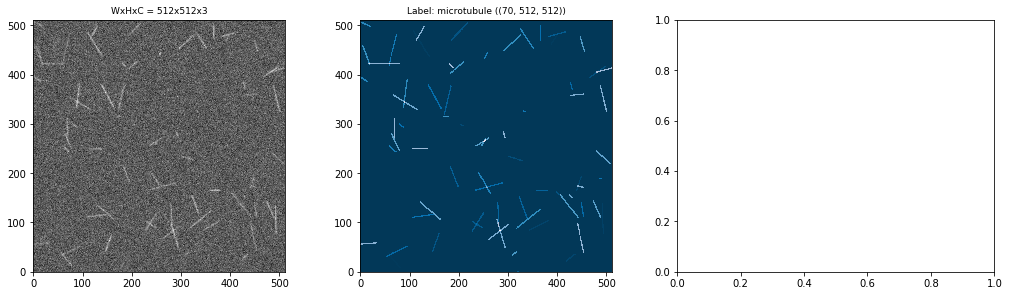

In [2]:
config['SOLVER']['IMS_PER_BATCH'] = 1
n_batch = 1

# Load some data
data_loader = maskflow.dataset.get_data_loader(config, data_dir, is_train=True)
some_data = [iter(data_loader).next() for _ in range(n_batch)]

# Retrieve category's names
categories = data_loader.dataset.coco.cats

for batch_image, batch_target, batch_idx in some_data:
    maskflow.viz.batch_display_top_masks(batch_image, batch_target, batch_idx, categories,
                                         basesize=14, limit=2, cmap="PuBu_r",
                                         pixel_mean=config['INPUT']['PIXEL_MEAN'],
                                         pixel_std=config['INPUT']['PIXEL_STD'])

## Training

In [ ]:
# Configure the training
config['DATA_DIR'] = str(data_dir)

config['MODEL']['DEVICE'] = "cuda"

config['DATALOADER']['NUM_WORKERS'] = 16
config['SOLVER']['IMS_PER_BATCH'] = 8

# Disable those settings if you want to use the training
# parameters from your config file.
custom_training = True
if custom_training:
    max_iter = 5000
    config['SOLVER']['MAX_ITER'] = max_iter
    config['SOLVER']['BASE_LR'] = 0.0005
    config['SOLVER']['STEPS'] = [int(max_iter * 0.66), int(max_iter * 0.9)]
    config['SOLVER']['CHECKPOINT_PERIOD'] = 1000
    config['SOLVER']['WARMUP_ITERS'] = 500

#config['SOLVER']

In [ ]:
# Setup training

# Use the last model in the model dir
# If False, create a new model from scratch.
# If `model_to_use` is set, we use this one instead.

builder_args = {}
builder_args['config'] = config
builder_args['model_dir'] = model_dir
builder_args['use_last_model'] = False
builder_args['model_to_use'] = None
builder_args['use_pretrained_weights'] = False
builder_args['distributed'] = False

training_args = maskflow.training.build_model(**builder_args)

2018-11-12 23:08:01,466:INFO:root: Training model directory set: /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Models/2018.11.12-23:08:01
2018-11-12 23:08:01,467:INFO:root: Building the model...


In [ ]:
# Run training

training_args['log_period'] = 10
training_args['log_losses_detailed'] = False
training_args['save_metrics'] = True
training_args['tensorboard'] = True
training_args['tensorboard_log_period'] = 10

maskflow.training.do_train(**training_args)